# Libero

In [60]:
import sys
from unittest.mock import MagicMock

# The Patch
mock_mpl = MagicMock()
sys.modules["matplotlib"] = mock_mpl
sys.modules["matplotlib.pyplot"] = mock_mpl
sys.modules["matplotlib.cm"] = mock_mpl
sys.modules["matplotlib.colors"] = mock_mpl
sys.modules["matplotlib.transforms"] = mock_mpl
sys.modules["matplotlib.ticker"] = mock_mpl
sys.modules["matplotlib._path"] = mock_mpl

In [61]:
import h5py
import numpy as np
from PIL import Image
from IPython.display import display, HTML

# Path to your demo file
file_path = "dataset/libero_spatial/pick_up_the_black_bowl_from_table_center_and_place_it_on_the_plate_demo.hdf5"

print(f"Opening file: {file_path}")

try:
    with h5py.File(file_path, "r") as f:
        # Loop through all demos in the file
        for demo_name in f["data"]:
            print(f"\n=== Demo: {demo_name} ===")
            
            # Access the image data (AgentView RGB)
            # Note: Ensure this path exists in your specific HDF5 structure
            if "obs/agentview_rgb" in f[f"data/{demo_name}"]:
                dataset = f[f"data/{demo_name}/obs/agentview_rgb"]
                num_images = dataset.shape[0]
                print(f"Total frames: {num_images}")
                
                # Pick indices: every 15th frame + the last one
                indices = list(range(0, num_images, 15))
                if num_images - 1 not in indices:
                    indices.append(num_images - 1)
                
                # Display images horizontally using HTML/PIL (No Matplotlib)
                images_html = []
                for idx in indices:
                    img_array = dataset[idx]
                    
                    # Convert numpy array to PIL Image
                    # (Robosuite images are usually already correct, but sometimes flipped)
                    img = Image.fromarray(img_array)
                    
                    # Resize for smaller display if needed
                    img_small = img.resize((128, 128)) 
                    
                    # Hack to display inline in loop
                    print(f"Frame {idx}:")
                    #display(img)
            else:
                print(f"Skipping {demo_name}: 'obs/agentview_rgb' not found.")
                
except Exception as e:
    print(f"An error occurred: {e}")

Opening file: dataset/libero_spatial/pick_up_the_black_bowl_from_table_center_and_place_it_on_the_plate_demo.hdf5

=== Demo: demo_0 ===
Total frames: 103
Frame 0:
Frame 15:
Frame 30:
Frame 45:
Frame 60:
Frame 75:
Frame 90:
Frame 102:

=== Demo: demo_1 ===
Total frames: 123
Frame 0:
Frame 15:
Frame 30:
Frame 45:
Frame 60:
Frame 75:
Frame 90:
Frame 105:
Frame 120:
Frame 122:

=== Demo: demo_10 ===
Total frames: 109
Frame 0:
Frame 15:
Frame 30:
Frame 45:
Frame 60:
Frame 75:
Frame 90:
Frame 105:
Frame 108:

=== Demo: demo_11 ===
Total frames: 101
Frame 0:
Frame 15:
Frame 30:
Frame 45:
Frame 60:
Frame 75:
Frame 90:
Frame 100:

=== Demo: demo_12 ===
Total frames: 124
Frame 0:
Frame 15:
Frame 30:
Frame 45:
Frame 60:
Frame 75:
Frame 90:
Frame 105:
Frame 120:
Frame 123:

=== Demo: demo_13 ===
Total frames: 122
Frame 0:
Frame 15:
Frame 30:
Frame 45:
Frame 60:
Frame 75:
Frame 90:
Frame 105:
Frame 120:
Frame 121:

=== Demo: demo_14 ===
Total frames: 114
Frame 0:
Frame 15:
Frame 30:
Frame 45:
Frame

# Libraries

In [62]:
import torch
import os
import torch.nn as nn
import numpy as np
import h5py
import einops
from torchvision import models
from torchvision.models import resnet18, ResNet18_Weights
from torchvision import transforms

# Verifica disponibilità GPU
print(f"PyTorch Version: {torch.__version__}")
if torch.cuda.is_available():
    print(f"✅ GPU Disponibile: {torch.cuda.get_device_name(0)}")
    device = torch.device("cuda")
else:
    print("⚠️ ATTENZIONE: GPU non rilevata. Vai su 'Settings' > 'Accelerator' e seleziona GPU P100 o T4.")
    device = torch.device("cpu")

# Verifica Einops (lo useremo molto nel modello ricorsivo)
print(f"Einops installato correttamente.")

# Configurazione base per riproducibilità (importante per la tesi)
def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)
print("✅ Ambiente pronto per il modello TinyRecursive.")

PyTorch Version: 2.9.1+cu128
✅ GPU Disponibile: NVIDIA GeForce RTX 3090 Ti
Einops installato correttamente.
✅ Ambiente pronto per il modello TinyRecursive.


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import h5py
# import matplotlib.pyplot as plt
from pathlib import Path
import cv2
from typing import Dict, List, Tuple, Optional, Any
from dataclasses import dataclass, asdict, replace
import json
import optuna
from datetime import datetime
from transformers import CLIPTokenizer, CLIPTextModel

# Setup device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Seed per riproducibilità
def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

# =========================
# Configuration utilities
# =========================

@dataclass
class TrainingConfig:
    """Container strutturato per gli iperparametri di training/model."""

    lr: float = 3e-4
    hidden_dim: int = 256
    num_recursions: int = 8
    epochs: int = 20
    batch_size: int = 64
    weight_decay: float = 1e-4
    grad_clip: Optional[float] = 1.0
    sched_T0: Optional[int] = None
    sched_T_mult: int = 1
    lr_min: float = 1e-6
    warmup_epochs: int = 3
    early_stop_patience: Optional[int] = None
    save_path: str = 'best_model.pt'
    freeze_backbone: bool = True
    augmentation: bool = False
    dropout: float = 0.1
    encoder_dropout: float = 0.1
    use_text_prompts: bool = True
    text_encoder_name: str = 'openai/clip-vit-large-patch14'
    train_text_encoder: bool = False
    text_dropout: float = 0.1
    double_visual_features: bool = False

    def to_dict(self) -> Dict[str, Any]:
        return asdict(self)

    def label(self) -> str:
        return f"lr{self.lr}_h{self.hidden_dim}_rec{self.num_recursions}_bs{self.batch_size}"


@dataclass
class HyperparameterSearchSpace:
    lr: List[float]
    hidden_dim: List[int]
    num_recursions: List[int]
    batch_size: List[int]
    weight_decay: List[float]
    pretrained_encoder: List[bool]
    freeze_backbone: List[bool]
    augmentation: List[bool]
    dropout: List[float]
    text_encoder_name: List[str]
    train_text_encoder: List[bool]
    text_dropout: List[float]
    double_visual_features: List[bool]
    use_text_prompts: List[bool] = None

    def as_optuna_space(self) -> Dict[str, List[Any]]:
        return {
            'lr': self.lr,
            'hidden_dim': self.hidden_dim,
            'num_recursions': self.num_recursions,
            'batch_size': self.batch_size,
            'weight_decay': self.weight_decay,
            'pretrained_encoder': self.pretrained_encoder,
            'freeze_backbone': self.freeze_backbone,
            'augmentation': self.augmentation,
            'dropout': self.dropout,
            'text_encoder_name': self.text_encoder_name,
            'train_text_encoder': self.train_text_encoder,
            'text_dropout': self.text_dropout,
            'double_visual_features': self.double_visual_features,
        }

# Numero 1
def default_search_space() -> HyperparameterSearchSpace:
    """Restituisce lo spazio di ricerca richiesto dall'utente."""

    return HyperparameterSearchSpace(
        lr=[0.001, 0.0002, 0.0001, 0.00005],
        hidden_dim=[256, 512, 768],
        num_recursions=[10, 12, 16],
        batch_size=[256, 512, 768],
        weight_decay=[0.1, 0.5, 1.0],
        pretrained_encoder=[True],
        freeze_backbone=[False],
        augmentation=[True],
        dropout=[0.1, 0.3, 0.5],
        text_encoder_name=[
            'openai/clip-vit-large-patch14'
        ],
        train_text_encoder=[False],
        use_text_prompts=[True, False],
        text_dropout=[0.1],
        double_visual_features=[False, True],
    )

Using device: cuda


✅ Trovati 10 file HDF5

📄 Analizzando: pick_up_the_black_bowl_next_to_the_plate_and_place_it_on_the_plate_demo.hdf5

🖼️ Usando chiave immagini: 'agentview_rgb'
  ✅ Immagini caricate: (115, 128, 128, 3)

🎮 Azioni caricate: (115, 7)
  Range: [-1.000, 1.000]

🎬 Visualizzazione frame esempio (PIL/IPython):
--- Frame 0 ---


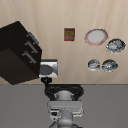

--- Frame 38 ---


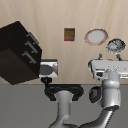

--- Frame 76 ---


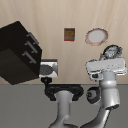

--- Frame 114 ---


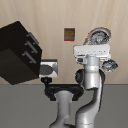

In [64]:
import numpy as np
import h5py
import sys
from pathlib import Path
from PIL import Image
from IPython.display import display

# --- HELPER FUNCTIONS (Kept largely the same) ---

def load_images_robust(dataset):
    """
    Carica immagini da dataset HDF5 usando metodo robusto.
    """
    shape = dataset.shape
    
    # METODO 1: Lettura diretta uint8
    try:
        buffer = np.empty(shape, dtype=np.uint8)
        dataset.read_direct(buffer)
        return buffer
    except Exception:
        pass
    
    # METODO 2: Float32 -> Uint8
    try:
        buffer = np.empty(shape, dtype=np.float32)
        dataset.read_direct(buffer)
        if buffer.max() <= 1.0:
            buffer = (buffer * 255).astype(np.uint8)
        else:
            buffer = np.clip(buffer, 0, 255).astype(np.uint8)
        return buffer
    except Exception:
        pass
    
    # METODO 3: Float64 -> Uint8
    try:
        buffer = np.empty(shape, dtype=np.float64)
        dataset.read_direct(buffer)
        if buffer.max() <= 1.0:
            buffer = (buffer * 255).astype(np.uint8)
        else:
            buffer = np.clip(buffer, 0, 255).astype(np.uint8)
        return buffer
    except Exception:
        pass

    # METODO 4: Fallback bytes
    try:
        buffer = np.empty(shape, dtype=np.uint8)
        dataset.id.read(h5py.h5s.ALL, h5py.h5s.ALL, buffer)
        return buffer
    except Exception as e:
        raise RuntimeError(f"Impossibile leggere il dataset: {e}")

def load_actions_robust(dataset):
    """
    Carica azioni da dataset HDF5.
    """
    shape = dataset.shape
    try:
        buffer = np.empty(shape, dtype=np.float32)
        dataset.read_direct(buffer)
        return buffer
    except Exception:
        pass
    
    try:
        buffer = np.empty(shape, dtype=np.float64)
        dataset.read_direct(buffer)
        return buffer.astype(np.float32)
    except Exception as e:
        raise RuntimeError(f"Impossibile leggere le azioni: {e}")

# --- MODIFIED EXPLORATION FUNCTION (No Matplotlib) ---

def explore_libero_dataset(data_path: Path):
    
    # Trova file
    hdf5_files = list(data_path.glob('**/*.hdf5'))
    
    if not hdf5_files:
        print(f"⚠️ Nessun file HDF5 trovato in {data_path}")
        return []
    
    print(f"✅ Trovati {len(hdf5_files)} file HDF5")
    
    # Analizza il primo file
    demo_file = hdf5_files[0]
    print(f"\n📄 Analizzando: {demo_file.name}")
    
    try:
        with h5py.File(demo_file, 'r') as f:
            if 'data' not in f:
                print("⚠️ Chiave 'data' non trovata")
                return hdf5_files
            
            data_group = f['data']
            demo_keys = list(data_group.keys())
            first_demo_key = demo_keys[0]
            demo_0 = data_group[first_demo_key]
            
            imgs = None
            
            # 1. Caricamento Immagini
            if 'obs' in demo_0:
                obs_group = demo_0['obs']
                
                # Strategia di ricerca chiave immagine
                image_keys = ['agentview_rgb', 'agentview_image', 'rgb', 'image', 'robot0_eye_in_hand_image']
                img_key = next((k for k in image_keys if k in obs_group), None)
                
                # Fallback ricerca generica
                if img_key is None:
                    img_key = next((k for k in obs_group.keys() if 'rgb' in k.lower() or 'image' in k.lower()), None)
                
                if img_key:
                    print(f"\n🖼️ Usando chiave immagini: '{img_key}'")
                    try:
                        imgs = load_images_robust(obs_group[img_key])
                        print(f"  ✅ Immagini caricate: {imgs.shape}")
                    except Exception as e:
                        print(f"  ❌ Errore immagini: {e}")
            
            # 2. Caricamento Azioni
            if 'actions' in demo_0:
                try:
                    actions = load_actions_robust(demo_0['actions'])
                    print(f"\n🎮 Azioni caricate: {actions.shape}")
                    print(f"  Range: [{actions.min():.3f}, {actions.max():.3f}]")
                except Exception as e:
                    print(f"  ❌ Errore azioni: {e}")

            # 3. VISUALIZZAZIONE (Senza Matplotlib)
            if imgs is not None and len(imgs) > 0:
                print("\n🎬 Visualizzazione frame esempio (PIL/IPython):")
                
                num_frames = min(4, len(imgs))
                indices = np.linspace(0, len(imgs) - 1, num_frames, dtype=int)
                
                for idx in indices:
                    img_array = imgs[idx]
                    
                    # Se l'immagine è float [0,1], converti a uint8
                    if img_array.dtype != np.uint8:
                         img_array = (np.clip(img_array, 0, 1) * 255).astype(np.uint8)
                    
                    # Crea immagine PIL
                    pil_img = Image.fromarray(img_array)
                    
                    # (Opzionale) Resize per non occupare troppo spazio
                    # pil_img = pil_img.resize((128, 128))
                    
                    print(f"--- Frame {idx} ---")
                    display(pil_img)
            else:
                print("\n⚠️ Nessuna immagine valida da visualizzare")

    except Exception as e:
        print(f"Errore critico durante l'apertura del file: {e}")
    
    return hdf5_files

# Esegui
hdf5_files = explore_libero_dataset(Path('dataset/libero_spatial'))

In [65]:
class LIBERODataset(Dataset):
    """
    Dataset per dimostrazioni LIBERO
    
    Carica osservazioni visive e azioni da file HDF5.
    Supporta data augmentation e normalizzazione.
    Gestisce automaticamente problemi di dtype non standard nei file HDF5.
    
    Supporta demo-level split: invece di dividere i file, divide le demo
    all'interno di ciascun file (es. 80% train, 20% val per ogni file).
    """
    
    def __init__(
        self,
        hdf5_files: List[Path],
        sequence_length: int = 1,
        image_size: Tuple[int, int] = (128, 128),
        normalize_actions: bool = True,
        augmentation: bool = False,
        max_demos_per_task: Optional[int] = None,
        demo_split_ratio: float = 0.8,
        is_train: bool = True,
        action_stats: Optional[Dict] = None
    ):
        """
        Args:
            hdf5_files: lista di path ai file HDF5
            sequence_length: lunghezza delle sequenze (1 = single-step prediction)
            image_size: dimensioni delle immagini
            normalize_actions: se True, normalizza le azioni con z-score
            augmentation: se True, applica data augmentation
            max_demos_per_task: limite massimo di demo per task (per debugging)
            demo_split_ratio: percentuale di demo per training (default 0.8 = 80%)
            is_train: se True, usa le prime demo_split_ratio% demo; se False, usa il resto
            action_stats: statistiche azioni pre-calcolate (per validation set)
        """
        self.hdf5_files = hdf5_files
        self.sequence_length = sequence_length
        self.image_size = (int(image_size[0]), int(image_size[1]))
        self.augmentation = augmentation and is_train
        self.normalize_actions = normalize_actions
        self.demo_split_ratio = demo_split_ratio
        self.is_train = is_train
        
        # Carica tutti i dati in memoria (assumendo dataset gestibile)
        self.data = []
        self.action_stats = action_stats if action_stats is not None else {'mean': None, 'std': None}
        self.samples: List[Tuple[int, int]] = []  # (demo_idx, start_idx)
        
        split_name = "TRAIN" if is_train else "VAL"
        print(f"Loading {len(hdf5_files)} HDF5 files for {split_name} (demo split: {demo_split_ratio:.0%})...")
        all_actions = []
        
        for hdf5_file in hdf5_files:
            try:
                with h5py.File(hdf5_file, 'r') as f:
                    if 'data' not in f:
                        print(f"⚠️ 'data' key not found in {hdf5_file.name}, skipping...")
                        continue
                    
                    demo_keys = list(f['data'].keys())
                    
                    # Limita numero di demo se richiesto
                    if max_demos_per_task is not None:
                        demo_keys = demo_keys[:max_demos_per_task]
                    
                    # Demo-level split: seleziona subset di demo in base a is_train
                    n_demos = len(demo_keys)
                    n_train_demos = int(n_demos * demo_split_ratio)
                    
                    if is_train:
                        # Training: prime n_train_demos demo
                        selected_demo_keys = demo_keys[:n_train_demos]
                    else:
                        # Validation: demo rimanenti
                        selected_demo_keys = demo_keys[n_train_demos:]
                    
                    if len(selected_demo_keys) == 0:
                        print(f"⚠️ No demos selected from {hdf5_file.name} for {split_name}, skipping...")
                        continue
                    
                    task_prompt = self._prompt_from_filename(hdf5_file)

                    for demo_key in selected_demo_keys:
                        try:
                            demo = f[f'data/{demo_key}']
                            
                            # Trova la chiave delle immagini
                            obs_group = demo['obs']
                            img_key = self._find_image_key(obs_group)
                            
                            if img_key is None:
                                print(f"⚠️ No image key found in {hdf5_file.name}/{demo_key}, skipping...")
                                continue
                            
                            # Carica osservazioni con metodo robusto
                            obs = self._load_images_robust(obs_group[img_key])
                            
                            # Carica azioni con metodo robusto
                            actions = self._load_actions_robust(demo['actions'])
                            
                            # Verifica che obs e actions abbiano lunghezze compatibili
                            min_len = min(len(obs), len(actions))
                            if min_len < self.sequence_length:
                                print(f"⚠️ Demo too short ({min_len} < {self.sequence_length}), skipping...")
                                continue
                            
                            obs = obs[:min_len]
                            actions = actions[:min_len]
                            
                            # Aggiungi alla lista
                            self.data.append({
                                'observations': obs,
                                'actions': actions,
                                'prompt': task_prompt
                            })
                            
                            all_actions.append(actions)
                            
                        except Exception as e:
                            print(f"⚠️ Error loading demo {demo_key} from {hdf5_file.name}: {e}")
                            continue
                            
            except Exception as e:
                print(f"❌ Error opening file {hdf5_file}: {e}")
                continue
        
        print(f"✅ Loaded {len(self.data)} demonstrations for {split_name}")
        
        if len(self.data) == 0:
            raise ValueError(f"No valid demonstrations loaded for {split_name}! Check your data files.")
        
        # Calcola statistiche azioni per normalizzazione (solo per training set o se non fornite)
        if self.normalize_actions and len(all_actions) > 0 and action_stats is None:
            all_actions_concat = np.concatenate(all_actions, axis=0)
        
            mean = all_actions_concat.mean(axis=0).astype(np.float32)
            std  = all_actions_concat.std(axis=0).astype(np.float32)
        
            # ⚠️ Floor di sicurezza: evita std troppo piccole che esplodono la normalizzazione
            std_clipped = np.clip(std, 0.1, None)
        
            # Log dettagliato
            print(f"📊 Action statistics computed from {split_name} set:")
            print(f"   Mean:        {np.round(mean, 3)}")
            print(f"   Std (raw):   {np.round(std, 3)}")
            print(f"   Std (clipped to >=0.1): {np.round(std_clipped, 3)}")
        
            self.action_stats['mean'] = mean
            self.action_stats['std']  = std_clipped
        
        elif action_stats is not None:
            print(f"📊 Using provided action statistics")
            self.action_stats = {
                'mean': action_stats['mean'].astype(np.float32),
                'std':  np.clip(action_stats['std'], 0.1, None).astype(np.float32)
            }

        # Costruisci indice delle transizioni per accesso O(1)
        self.samples = self._build_sample_index()
        print(f"📦 Generated {len(self.samples)} transitions for {split_name}")

    @staticmethod
    def _prompt_from_filename(hdf5_file: Path) -> str:
        """Converte il nome del file HDF5 in un prompt naturale."""
        name = hdf5_file.stem
        if name.endswith('_demo'):
            name = name[:-5]
        name = name.replace('_', ' ').replace('-', ' ')
        return ' '.join(name.split()).strip()

    
    def _find_image_key(self, obs_group) -> Optional[str]:
        """Trova la chiave corretta per le immagini nel gruppo obs"""
        # Lista di possibili chiavi per le immagini (in ordine di priorità)
        possible_keys = [
            'agentview_rgb',
            'agentview_image', 
            'rgb',
            'image',
            'robot0_eye_in_hand_image',
            'frontview_image',
            'sideview_image'
        ]
        
        obs_keys = list(obs_group.keys())
        
        # Prima cerca chiavi note
        for key in possible_keys:
            if key in obs_keys:
                return key
        
        # Poi cerca qualsiasi chiave che contiene 'rgb' o 'image'
        for key in obs_keys:
            if 'rgb' in key.lower() or 'image' in key.lower():
                return key
        
        return None
    
    def _load_images_robust(self, dataset) -> np.ndarray:
        """
        Carica immagini da dataset HDF5 usando metodo robusto che bypassa problemi dtype.
        """
        shape = dataset.shape
        
        # METODO 1: Prova lettura diretta come uint8
        try:
            buffer = np.empty(shape, dtype=np.uint8)
            dataset.read_direct(buffer)
            return buffer
        except Exception:
            pass
        
        # METODO 2: Prova come float32 e converti
        try:
            buffer = np.empty(shape, dtype=np.float32)
            dataset.read_direct(buffer)
            if buffer.max() <= 1.0:
                buffer = (buffer * 255).astype(np.uint8)
            else:
                buffer = np.clip(buffer, 0, 255).astype(np.uint8)
            return buffer
        except Exception:
            pass
        
        # METODO 3: Prova come float64
        try:
            buffer = np.empty(shape, dtype=np.float64)
            dataset.read_direct(buffer)
            if buffer.max() <= 1.0:
                buffer = (buffer * 255).astype(np.uint8)
            else:
                buffer = np.clip(buffer, 0, 255).astype(np.uint8)
            return buffer
        except Exception:
            pass
        
        # METODO 4: Lettura raw
        try:
            buffer = np.empty(shape, dtype=np.uint8)
            dataset.id.read(h5py.h5s.ALL, h5py.h5s.ALL, buffer)
            return buffer
        except Exception as e:
            raise RuntimeError(f"Cannot read image dataset: {e}")
    
    def _load_actions_robust(self, dataset) -> np.ndarray:
        """
        Carica azioni da dataset HDF5 usando metodo robusto.
        """
        shape = dataset.shape
        
        # METODO 1: Prova lettura diretta come float32
        try:
            buffer = np.empty(shape, dtype=np.float32)
            dataset.read_direct(buffer)
            return buffer
        except Exception:
            pass
        
        # METODO 2: Prova come float64 e converti
        try:
            buffer = np.empty(shape, dtype=np.float64)
            dataset.read_direct(buffer)
            return buffer.astype(np.float32)
        except Exception as e:
            raise RuntimeError(f"Cannot read actions dataset: {e}")
    
    def _build_sample_index(self) -> List[Tuple[int, int]]:
        """Pre-calcola gli indici (demo_idx, start_idx) per ogni transizione"""
        indices: List[Tuple[int, int]] = []
        for demo_idx, demo in enumerate(self.data):
            demo_transitions = len(demo['observations']) - self.sequence_length + 1
            if demo_transitions <= 0:
                continue
            indices.extend((demo_idx, start) for start in range(demo_transitions))
        if not indices:
            raise ValueError("Dataset index is empty after preprocessing")
        return indices

    def __len__(self) -> int:
        """Numero totale di transizioni disponibili"""
        return len(self.samples)
    
    def __getitem__(self, idx: int) -> Dict[str, torch.Tensor]:
        """
        Restituisce una transizione (osservazione, azione).
        
        Args:
            idx: indice della transizione
            
        Returns:
            Dict con 'observations' e 'actions' come tensori
        """
        demo_idx, start_idx = self.samples[idx]
        demo = self.data[demo_idx]
        end_idx = start_idx + self.sequence_length

        obs = demo['observations'][start_idx:end_idx].copy()
        actions = demo['actions'][start_idx:end_idx].copy()

        # Preprocessing
        obs = self._preprocess_obs(obs)
        actions = self._preprocess_actions(actions)

        # Per single-step prediction, restituisci solo primo elemento
        if self.sequence_length == 1:
            obs = obs[0]
            actions = actions[0]

        # Converti HWC -> CHW per PyTorch
        if obs.ndim == 3:  # Single image: (H, W, C) -> (C, H, W)
            obs = np.transpose(obs, (2, 0, 1))
        elif obs.ndim == 4:  # Sequence: (T, H, W, C) -> (T, C, H, W)
            obs = np.transpose(obs, (0, 3, 1, 2))

        return {
            'observations': torch.from_numpy(obs).float(),
            'actions': torch.from_numpy(actions).float(),
            'prompt': demo.get('prompt', '')
        }
    
    def _preprocess_obs(self, obs: np.ndarray) -> np.ndarray:
        """Preprocessing delle osservazioni"""
        processed = []
        target_h, target_w = self.image_size
        for img in obs:
            if img.shape[0] != target_h or img.shape[1] != target_w:
                img = cv2.resize(img, (target_w, target_h), interpolation=cv2.INTER_AREA)
            processed.append(img)
        obs = np.stack(processed, axis=0)

        # Normalizza [0, 255] -> [0, 1]
        obs = obs.astype(np.float32) / 255.0

        # Data augmentation (se abilitato)
        if self.augmentation:
            obs = self._augment_obs(obs)
        
        return obs
    def _augment_obs(self, obs: np.ndarray) -> np.ndarray:
        """Data augmentation per osservazioni"""
        # Color jitter (brightness)
        if np.random.rand() < 0.5:
            brightness = np.random.uniform(0.8, 1.2)
            obs = np.clip(obs * brightness, 0, 1)
        
        # Contrast adjustment
        if np.random.rand() < 0.3:
            contrast = np.random.uniform(0.8, 1.2)
            mean = obs.mean(axis=(1, 2), keepdims=True)
            obs = np.clip((obs - mean) * contrast + mean, 0, 1)
        
        # Random crop (con padding)
        if np.random.rand() < 0.3:
            crop_ratio = np.random.uniform(0.85, 0.95)
            crop_size_h = int(self.image_size[0] * crop_ratio)
            crop_size_w = int(self.image_size[1] * crop_ratio)
            
            start_y = np.random.randint(0, self.image_size[0] - crop_size_h + 1)
            start_x = np.random.randint(0, self.image_size[1] - crop_size_w + 1)
            
            cropped = []
            for img in obs:
                img_crop = img[start_y:start_y+crop_size_h, start_x:start_x+crop_size_w]
                img_resized = cv2.resize(img_crop, (self.image_size[1], self.image_size[0]))
                cropped.append(img_resized)
            obs = np.stack(cropped)
        
        return obs
    
    def _preprocess_actions(self, actions: np.ndarray) -> np.ndarray:
        """Preprocessing delle azioni con normalizzazione z-score"""
        actions = actions.astype(np.float32)
        if self.action_stats['mean'] is not None:
            actions = (actions - self.action_stats['mean']) / self.action_stats['std']
        
        return actions
    
    def get_action_stats(self) -> Dict[str, np.ndarray]:
        """Restituisce le statistiche delle azioni per denormalizzazione"""
        return self.action_stats.copy()
    
    def denormalize_actions(self, actions: np.ndarray) -> np.ndarray:
        """Denormalizza le azioni per l'esecuzione nel simulatore"""
        if self.action_stats['mean'] is not None:
            return actions * self.action_stats['std'] + self.action_stats['mean']
        return actions

In [ ]:
class PretrainedVisualEncoder(nn.Module):
    """Visual encoder basato su ResNet18 con testa adattiva."""

    def __init__(self, hidden_dim: int = 256, freeze_backbone: bool = True, dropout: float = 0.1, double_visual_features: bool = False):
        super().__init__()

        self.hidden_dim = hidden_dim

        resnet = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

        if freeze_backbone:
            for param in resnet.parameters():
                param.requires_grad = False

        self.backbone = nn.Sequential(*list(resnet.children())[:-1])

        self.adapter = nn.Sequential(
            nn.Linear(512, 512),
            nn.GELU(),
            nn.Dropout(dropout),
            double_visual_features and nn.Linear(512, hidden_dim * 2) or # se double_visual_features è true le features sono doppie
            nn.Linear(512, hidden_dim) 
        )
        self.ln = nn.LayerNorm(hidden_dim * (2 if double_visual_features else 1))

        self.register_buffer('mean', torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1))
        self.register_buffer('std', torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1))

        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.float()

        if x.shape[-1] != 224 or x.shape[-2] != 224:
            x = nn.functional.interpolate(x, size=(224, 224), mode='bilinear', align_corners=False)

        x = (x - self.mean) / self.std
        features = self.backbone(x).flatten(start_dim=1) # [B, 512]
        #output = self.adapter(features) # da provare a passargli direttamente le features invece dell'adapter
        return features

class PromptEncoder(nn.Module):
    """Encodes natural-language task prompts via CLIP ViT-L/14 text tower."""

    def __init__(
        self,
        hidden_dim: int,
        model_name: str = 'openai/clip-vit-large-patch14',
        trainable: bool = False,
        dropout: float = 0.3,
        max_length: int = 77
    ):
        super().__init__()

        self.tokenizer = CLIPTokenizer.from_pretrained(model_name)
        self.text_model = CLIPTextModel.from_pretrained(model_name)
        self.max_length = min(max_length, getattr(self.text_model.config, 'max_position_embeddings', max_length))

        if not trainable:
            self.text_model.eval()
            for param in self.text_model.parameters():
                param.requires_grad = False

        self.text_hidden = self.text_model.config.hidden_size
        self.adapter = nn.Sequential(
            nn.LayerNorm(self.text_hidden),
            nn.Linear(self.text_hidden, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout)
        )

        self._token_cache: Dict[str, Dict[str, torch.Tensor]] = {}

    def _tokenize(self, prompt: str) -> Dict[str, torch.Tensor]:
        if prompt not in self._token_cache:
            tokens = self.tokenizer(
                prompt,
                return_tensors='pt',
                padding='max_length',
                truncation=True,
                max_length=self.max_length
            )
            self._token_cache[prompt] = {k: v for k, v in tokens.items()}
        cached = self._token_cache[prompt]
        return {k: v.clone() for k, v in cached.items()}

    def forward(self, prompts: List[str], device: torch.device) -> torch.Tensor:
        if len(prompts) == 0:
            raise ValueError("PromptEncoder received an empty batch of prompts")

        token_batches = [self._tokenize(p) for p in prompts]
        batch = {
            key: torch.cat([tokens[key] for tokens in token_batches], dim=0).to(device)
            for key in token_batches[0]
        }

        outputs = self.text_model(**batch) # B, 768
        pooled = outputs.pooler_output if outputs.pooler_output is not None else outputs.last_hidden_state[:, -1, :]
        return self.adapter(pooled)


class RecursiveBlock(nn.Module):
    """
    Blocco ricorsivo del TRM.
    Implementa il ragionamento iterativo con self-attention e MLP.
    """
    
    def __init__(self, hidden_dim=256, num_heads=4, dropout=0.1):
        super().__init__()
        
        # Self-attention per ragionamento
        self.attention = nn.MultiheadAttention(
            hidden_dim,
            num_heads,
            dropout=dropout,
            batch_first=True
        )
        self.norm = nn.LayerNorm(hidden_dim)
        self.dropout = nn.Dropout(dropout)
        
        # MLP per trasformazione
        self.mlp = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim * 4),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim * 4, hidden_dim),
            nn.Dropout(dropout)
        )
    
    def forward(self, h, x_cond):
        """
        Args:
            h: (B, D) hidden state corrente
            x_cond: (B, D) conditioning dall'input
        Returns:
            (B, D) nuovo hidden state
        """
        h_in = h.unsqueeze(1)        # (B, 1, D)
        cond = x_cond.unsqueeze(1)   # (B, 1, D)

        # Cross-attention: query = h, key/value = x_cond
        attn_out, _ = self.attention(h_in, cond, cond)
        attn_out = self.dropout(attn_out)
        
        # MLP + residual
        x = self.norm(attn_out + self.mlp(attn_out)) # (B, D)
        #x = self.norm(h_in + self.mlp(h_in)) VERSIONE SENZA ATTENTION
        return x.squeeze(1)

class CrossAttentionFusion(nn.Module): # Prova della fusione con cross-attention da testo a visuale, provato anche da visuale a testo
    def __init__(self, visual_dim: int, text_dim: int, hidden_dim: int, num_heads: int = 4, dropout: float = 0.1):
        super().__init__()
        self.query_proj = nn.Linear(text_dim, hidden_dim)
        self.key_proj = nn.Linear(visual_dim, hidden_dim)
        self.value_proj = nn.Linear(visual_dim, hidden_dim)
        self.attn = nn.MultiheadAttention(hidden_dim, num_heads, dropout=dropout, batch_first=True)
        self.resid_norm = nn.LayerNorm(hidden_dim)
        self.ffn = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim * 2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.Dropout(dropout)
        )
        self.out_norm = nn.LayerNorm(hidden_dim)

    def forward(self, visual_feats: torch.Tensor, text_feats: torch.Tensor) -> torch.Tensor:
        q = self.query_proj(text_feats).unsqueeze(1)
        k = self.key_proj(visual_feats).unsqueeze(1)
        v = self.value_proj(visual_feats).unsqueeze(1)
        attn_out, _ = self.attn(q, k, v)
        fused = self.resid_norm(q + attn_out)
        fused = self.out_norm(fused + self.ffn(fused))
        return fused.squeeze(1)

class TRMPolicy(nn.Module):
    """
    Policy completa basata su Tiny
    Models per controllo robotico.
    
    Architettura:
    1. Visual Encoder: CNN (custom o ResNet pre-trained) per estrarre features da immagini
    2. Recursive Block: applicato N volte per ragionamento iterativo
    3. Action Head: predice azioni da ultimo hidden state
    
    NOTA: Aspetta input in formato PyTorch standard (B, C, H, W)
    """
    
    def __init__(
        self,
        obs_shape=(3, 128, 128),  # Formato CHW (PyTorch standard)
        action_dim=7,
        hidden_dim=256,
        num_heads=4,
        num_recursions=8,
        dropout=0.1,
        freeze_backbone=True,
        encoder_dropout=0.1,
        use_text_prompts=True,
        text_encoder_name='openai/clip-vit-large-patch14',
        train_text_encoder=False,
        text_dropout=0.1,
        double_visual_features=False
    ):
        super().__init__()
        
        self.hidden_dim = hidden_dim
        self.num_recursions = num_recursions
        self.obs_shape = obs_shape
        self.use_text_prompts = use_text_prompts
        
        # Selezione encoder

        self.encoder = PretrainedVisualEncoder(
            hidden_dim=hidden_dim,
            freeze_backbone=freeze_backbone,
            dropout=encoder_dropout,
            double_visual_features=double_visual_features
        )
        
        visual_dim = hidden_dim * (2 if double_visual_features else 1)
        if self.use_text_prompts:
            self.prompt_encoder = PromptEncoder(
                hidden_dim=hidden_dim,
                model_name=text_encoder_name,
                trainable=train_text_encoder,
                dropout=text_dropout
            )
            # self.fusion_adapter = CrossAttentionFusion(
            #     visual_dim=visual_dim,
            #     text_dim=hidden_dim,
            #     hidden_dim=hidden_dim,
            #     num_heads=num_heads,
            #     dropout=dropout
            # )
            fusion_in = visual_dim + hidden_dim
            
        else:
            self.prompt_encoder = None
            fusion_in = visual_dim 
        
        if fusion_in != hidden_dim: # se le dimensioni non combaciano, usa un adapter 
            self.fusion_adapter = nn.Sequential(
                nn.LayerNorm(fusion_in),
                nn.Linear(fusion_in, hidden_dim),
                nn.GELU(),
                nn.Dropout(dropout)
            )
        else:
            self.fusion_adapter = nn.Identity()
        # Recursive block
        self.recursive_block = RecursiveBlock(hidden_dim, num_heads, dropout)
        
        # Action head
        self.action_head = nn.Sequential(
            nn.LayerNorm(hidden_dim),
            nn.Linear(hidden_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, action_dim)
        )
        
    def forward(self, obs, prompts: Optional[List[str]] = None, return_all_states=False):
        """
        Args:
            obs: (B, C, H, W) osservazioni in formato CHW (PyTorch standard)
            prompts: lista di stringhe (B) con la descrizione del task
            return_all_states: se True, restituisce tutti gli hidden states
        Returns:
            actions: (B, action_dim) azioni predette
            (opzionale) states: lista di hidden states
        """
        B = obs.shape[0]
        
        # Encoding iniziale
        x_cond = self.encoder(obs)

        if self.use_text_prompts:
            if prompts is None:
                raise ValueError("TRMPolicy richiede i prompt testuali quando use_text_prompts=True")
            text_features = self.prompt_encoder(prompts, device=obs.device)
            x_cond = self.fusion_adapter(torch.cat([x_cond, text_features], dim=-1)) 
        else:
            x_cond = self.fusion_adapter(x_cond)
        h = x_cond.clone()
        
        states = [h] if return_all_states else None
        
        # Applicazione ricorsiva del blocco

        for t in range(self.num_recursions):
            h = self.recursive_block(h, x_cond)
            if return_all_states:
                states.append(h)
        
        # Predizione azione
        actions = self.action_head(h)
        
        if return_all_states:
            return actions, states
        return actions
    
def build_policy_from_config(config: TrainingConfig, obs_shape: Tuple[int, int, int] = (3, 128, 128)) -> TRMPolicy:
    """Costruisce una TRMPolicy coerente con il TrainingConfig."""

    return TRMPolicy(
        obs_shape=obs_shape,
        action_dim=7,
        hidden_dim=config.hidden_dim,
        num_recursions=config.num_recursions,
        dropout=config.dropout,
        freeze_backbone=config.freeze_backbone,
        encoder_dropout=config.encoder_dropout,
        use_text_prompts=config.use_text_prompts,
        text_encoder_name=config.text_encoder_name,
        train_text_encoder=config.train_text_encoder,
        text_dropout=config.text_dropout,
        double_visual_features=config.double_visual_features
    )

print("ok")

ok


In [67]:
class BehaviorCloningTrainer:
    """Trainer per Behavior Cloning con configurazione strutturata."""

    def __init__(
        self,
        model: nn.Module,
        train_loader: DataLoader,
        val_loader: DataLoader,
        config: TrainingConfig,
        device: torch.device
    ):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.config = config
        self.device = device
        self.steps_per_epoch = max(len(train_loader), 1)

        # Optimizer e scheduler
        self.optimizer = torch.optim.AdamW(
            model.parameters(),
            lr=config.lr,
            weight_decay=config.weight_decay
        )

        self.scheduler = None
        
        self.use_amp = (self.device.type == 'cuda')
        self.scaler = torch.cuda.amp.GradScaler(enabled=self.use_amp)
        self.grad_clip = config.grad_clip
        self.early_stop_patience = config.early_stop_patience
        self._epochs_no_improve = 0

        self.best_val_loss = float('inf')
        self.best_model_path = config.save_path
    
    def train(self):
        """Training loop completo"""
        
        for epoch in range(self.config.epochs):
            # Training
            train_metrics = self._train_epoch(epoch)
            
            # Validation
            val_metrics = self._validate_epoch(epoch)
            print(f"Epoch {epoch}, training loss: {train_metrics['loss']}, validation loss: {val_metrics['loss']}")
            # Logging exaustive
            self._log_metrics(epoch, train_metrics, val_metrics)

            # print(f"Epoch: {epoch}\n\t Training: {train_metrics}\n\t Validation: {val_metrics}")
            
            # Save best model
            if val_metrics['loss'] < self.best_val_loss:
                self.best_val_loss = val_metrics['loss']
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': self.model.state_dict(),
                    'optimizer_state_dict': self.optimizer.state_dict(),
                    'val_loss': val_metrics['loss'],
                    'config': self.config.to_dict()
                }, self.best_model_path)
                print(f"  ✓ Saved best model (val_loss: {val_metrics['loss']:.4f})")
                self._epochs_no_improve = 0
            else:
                self._epochs_no_improve += 1

            if self.early_stop_patience and self._epochs_no_improve >= self.early_stop_patience:
                print("⏹️  Early stopping triggered")
                break
        
        print(f"\n✅ Training completed! Best val loss: {self.best_val_loss:.4f}")
        return self.best_val_loss
    
    def _train_epoch(self, epoch):
        """Training per una epoch"""
        self.model.train()
        
        total_loss = 0
        action_mse = 0
        action_l1 = 0
        
        for step, batch in enumerate(self.train_loader):
            obs = batch['observations'].to(self.device, non_blocking=True)
            target_actions = batch['actions'].to(self.device, non_blocking=True)
            prompts = batch.get('prompt')

            self.optimizer.zero_grad(set_to_none=True)

            with torch.cuda.amp.autocast(enabled=self.use_amp):
                pred_actions = self.model(obs, prompts=prompts)
                mse = F.mse_loss(pred_actions, target_actions)
                l1 = F.l1_loss(pred_actions, target_actions)
                loss = 0.7 * mse + 0.3 * l1

            if self.use_amp:
                self.scaler.scale(loss).backward()
                if self.grad_clip:
                    self.scaler.unscale_(self.optimizer)
                    torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.grad_clip)
                self.scaler.step(self.optimizer)
                self.scaler.update()
            else:
                loss.backward()
                if self.grad_clip:
                    torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.grad_clip)
                self.optimizer.step()

            total_loss += loss.item()
            action_mse += mse.item()
            action_l1 += l1.item()

            if self.scheduler is not None:
                self.scheduler.step()

        n_batches = len(self.train_loader)
        return {
            'loss': total_loss / n_batches,
            'action_mse': action_mse / n_batches,
            'action_l1': action_l1 / n_batches
        }
    
    def _validate_epoch(self, epoch):
        """Validation per una epoch"""
        self.model.eval()
        
        total_loss = 0
        action_mse = 0
        action_l1 = 0
        
        with torch.no_grad():
            
            for batch in self.val_loader:
                obs = batch['observations'].to(self.device)
                target_actions = batch['actions'].to(self.device)
                prompts = batch.get('prompt')
                
                # Forward pass
                pred_actions = self.model(obs, prompts=prompts)
                
                # Loss
                mse = F.mse_loss(pred_actions, target_actions)
                l1 = F.l1_loss(pred_actions, target_actions)
                loss = 0.7 * mse + 0.3 * l1
                
                total_loss += loss.item()
                action_mse += mse.item()
                action_l1 += l1.item()
                
        
        n_batches = len(self.val_loader)
        return {
            'loss': total_loss / n_batches,
            'action_mse': action_mse / n_batches,
            'action_l1': action_l1 / n_batches
        }
    
    def _log_metrics(self, epoch, train_metrics, val_metrics):
        """Log delle metriche"""
        lr = self.optimizer.param_groups[0]['lr']
        
        # WandB logging
        

def build_dataloaders(
    train_dataset: Dataset,
    val_dataset: Dataset,
    batch_size: int,
    loader_kwargs: Dict[str, Any]
) -> Tuple[DataLoader, DataLoader]:
    """Crea data loader consistenti a partire da un template di kwargs."""

    kwargs = loader_kwargs.copy()
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        drop_last=True,
        **kwargs
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        drop_last=False,
        **kwargs
    )

    return train_loader, val_loader


def _set_dataset_augmentation(dataset, flag: bool):
    """Imposta augmentation temporaneamente e restituisce funzione di restore."""

    if not hasattr(dataset, 'augmentation'):
        return lambda: None

    original = dataset.augmentation
    dataset.augmentation = flag

    def restore():
        dataset.augmentation = original

    return restore


def optuna_random_search(
    train_dataset: Dataset,
    val_dataset: Dataset,
    loader_kwargs: Dict[str, Any],
    device: torch.device,
    quick_epochs: int = 10,
    search_space: Optional[HyperparameterSearchSpace] = None,
    n_trials: int = 50
) -> Tuple[TrainingConfig, List[Dict[str, Any]]]:
    """
    Randomized Optuna search (TPE-based) instead of grid-search.
    Runs a fixed number of trials (n_trials).
    """

    search_space = search_space or default_search_space()

    # --- NEW: TPE Sampler (recommended over random sampling) ---
    sampler = optuna.samplers.TPESampler(seed=42)

    study = optuna.create_study(
        direction='minimize',
        sampler=sampler
    )

    print(f"\n🔍 Starting Optuna random search")
    print(f"  Number of trials: {n_trials}")
    print(f"  Quick epochs: {quick_epochs}")

    def objective(trial: optuna.Trial) -> float:

        # --- Suggest values from the search space ---
        trial_config = TrainingConfig(
            lr=trial.suggest_categorical('lr', search_space.lr),
            hidden_dim=trial.suggest_categorical('hidden_dim', search_space.hidden_dim),
            num_recursions=trial.suggest_categorical('num_recursions', search_space.num_recursions),
            epochs=quick_epochs,
            batch_size=trial.suggest_categorical('batch_size', search_space.batch_size),
            weight_decay=trial.suggest_categorical('weight_decay', search_space.weight_decay),
            freeze_backbone=trial.suggest_categorical('freeze_backbone', search_space.freeze_backbone),
            augmentation=trial.suggest_categorical('augmentation', search_space.augmentation),
            dropout=trial.suggest_categorical('dropout', search_space.dropout),
            encoder_dropout=trial.suggest_categorical('dropout', search_space.dropout),
            use_text_prompts=trial.suggest_categorical('use_text_prompts', search_space.use_text_prompts),
            text_encoder_name=trial.suggest_categorical('text_encoder_name', search_space.text_encoder_name),
            train_text_encoder=trial.suggest_categorical('train_text_encoder', search_space.train_text_encoder),
            text_dropout=trial.suggest_categorical('text_dropout', search_space.text_dropout),
            double_visual_features=trial.suggest_categorical('double_visual_features', search_space.double_visual_features),
            grad_clip=1.0,
            save_path=f"optuna_trial_{trial.number}.pt"
        )

        print("-" * 80)
        print(f"[Optuna] Trial {trial.number + 1}/{n_trials}")
        print(json.dumps(trial_config.to_dict(), indent=2))
        sys.stdout.flush()

        # Build dataloaders based on this trial's batch size
        train_loader, val_loader = build_dataloaders(
            train_dataset,
            val_dataset,
            trial_config.batch_size,
            loader_kwargs
        )

        # Build model
        model = build_policy_from_config(trial_config)
        trainer = BehaviorCloningTrainer(
            model,
            train_loader,
            val_loader,
            trial_config,
            device
        )

        # Turn augmentation on/off safely
        restore_aug = _set_dataset_augmentation(train_dataset, trial_config.augmentation)

        try:
            val_loss = trainer.train()
        finally:
            restore_aug()

        # Store config inside trial for later retrieval
        trial.set_user_attr('config', trial_config.to_dict())

        return val_loss

    # --- NEW: Run fixed-size random search ---
    study.optimize(objective, n_trials=n_trials)

    # Save trial history (full information)
    history = []
    for trial in study.trials:
        history.append({
            'trial_number': trial.number,
            'state': str(trial.state),
            'value': trial.value,
            'params': trial.params,                # all parameters sampled
            'user_attrs': trial.user_attrs,        # user metadata (our config)
            'distributions': {
                k: str(v) for k, v in trial.distributions.items()
            },                                      # searchable distributions
            'system_attrs': trial.system_attrs,    # optuna internal info
            'datetime_start': str(trial.datetime_start),
            'datetime_complete': str(trial.datetime_complete),
        })


    # Best configuration
    best_config = TrainingConfig(**study.best_trial.user_attrs['config'])

    return best_config, history

In [68]:
def train_final_model(
    base_config: TrainingConfig,
    train_dataset: Dataset,
    val_dataset: Dataset,
    loader_kwargs: Dict[str, Any],
    device,
    final_epochs: Optional[int] = None
) -> Tuple[nn.Module, float]:
    """Esegue il training finale a partire dalla configurazione scelta."""

    final_epochs = final_epochs or base_config.epochs
    final_config = replace(
        base_config,
        epochs=final_epochs,
        save_path='models/modello.pt',
        early_stop_patience=base_config.early_stop_patience or 10,
        sched_T0=base_config.sched_T0 or max(1, final_epochs // 5)
    )

    print(f"\n{'='*60}")
    print("🎯 FINAL TRAINING")
    print(f"Config: {final_config.label()}")
    print(f"{'='*60}")

    train_loader, val_loader = build_dataloaders(
        train_dataset,
        val_dataset,
        final_config.batch_size,
        loader_kwargs
    )

    model = build_policy_from_config(final_config)
    trainer = BehaviorCloningTrainer(
        model,
        train_loader,
        val_loader,
        final_config,
        device
    )

    restore_aug = _set_dataset_augmentation(train_dataset, final_config.augmentation)
    try:
        final_val_loss = trainer.train()
    finally:
        restore_aug()

    if os.path.exists(final_config.save_path):
        checkpoint = torch.load(final_config.save_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])


    print(f"\n✅ Final model trained! Val loss: {final_val_loss:.4f}")

    return model, final_val_loss

In [69]:
def main_pipeline(
    data_path: str = 'dataset/libero_spatial',
    quick_search: bool = True,
    train_final: bool = True,
    use_custom_final_config: bool = False,
    evaluate: bool = True
):
    """
    Pipeline completa per il progetto TRM Robotics
    
    Args:
        data_path: path ai dati LIBERO
        quick_search: se True, esegue hyperparameter search
        train_final: se True, esegue training finale
        evaluate: se True, esegue valutazione in simulazione
    """
    
    print(f"""
    {'='*80}
    🤖 TinyRecursiveModels per Controllo Robotico
    {'='*80}
    
    Obiettivi:
    1. Adattare architettura TRM per robotica
    2. Training con Behavior Cloning su LIBERO
    3. Valutazione in simulazione con metriche quantitative e qualitative
    
    """)
    
    # Device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"✓ Using device: {device}\n")
    
    # ========== STEP 1: Caricamento Dataset ==========
    print(f"\n{'='*80}")
    print("STEP 1: Caricamento Dataset")
    print(f"{'='*80}")
    
    # Trova file HDF5
    data_path = Path(data_path)
    hdf5_files = list(data_path.glob('**/*.hdf5'))
    
    if not hdf5_files:
        print(f"❌ Nessun file HDF5 trovato in {data_path}")
        print("Assicurati di aver scaricato il dataset LIBERO!")
        return
    
    print(f"✓ Trovati {len(hdf5_files)} file HDF5 (task)")
    
    # Demo-level split: usa TUTTI i file per entrambi i dataset
    # ma dividi le demo all'interno di ciascun file (80% train, 20% val)
    demo_split_ratio = 0.8
    print(f"\n📊 Demo-level split: {demo_split_ratio:.0%} train / {1-demo_split_ratio:.0%} val per ogni task")
    print(f"   Tutti i {len(hdf5_files)} task presenti in entrambi train e val")
    
    # Crea datasets con demo-level split
    print("\nCreating TRAIN dataset...")
    train_dataset = LIBERODataset(
        hdf5_files,  # Usa TUTTI i file
        sequence_length=1,
        image_size=(128, 128),
        augmentation=False,
        max_demos_per_task=50,  # Limita per velocità
        demo_split_ratio=demo_split_ratio,
        is_train=True  # Prime 80% demo per task
    )
    
    # Usa le stesse statistiche del training set per la validation
    train_action_stats = train_dataset.action_stats
    
    print("\nCreating VAL dataset...")
    val_dataset = LIBERODataset(
        hdf5_files,  # Usa TUTTI i file
        sequence_length=1,
        image_size=(128, 128),
        augmentation=False,
        max_demos_per_task=50,  # Stesso limite per coerenza
        demo_split_ratio=demo_split_ratio,
        is_train=False,  # Ultime 20% demo per task
        action_stats=train_action_stats  # Usa statistiche del training
    )
    
    # Data loader template (verranno istanziati on-demand)
    num_workers = min(4, os.cpu_count() or 1)
    use_cuda = torch.cuda.is_available()

    loader_common = {
        'num_workers': num_workers,
        'pin_memory': use_cuda,
        'persistent_workers': num_workers > 0
    }
    if num_workers > 0:
        loader_common['prefetch_factor'] = 2

    print(f"\n✓ Dataset creati con demo-level split")
    print(f"  Train samples: {len(train_dataset)}")
    print(f"  Val samples: {len(val_dataset)}")
    
    # Salva action stats per denormalizzazione
    action_stats = train_dataset.action_stats
    with open('action_stats.json', 'w') as f:
        json.dump({
            'mean': action_stats['mean'].tolist(),
            'std': action_stats['std'].tolist()
        }, f)
    
    # ========== STEP 2: Hyperparameter Search ==========
    best_config = None
    
    if quick_search:
        print(f"\n{'='*80}")
        print("STEP 2: Hyperparameter Search")
        print(f"{'='*80}")
        
        best_config, all_results = optuna_random_search(
            train_dataset,
            val_dataset,
            loader_common,
            device,
            quick_epochs=12
        )
        
        # Salva risultati
        with open('hyperparam_results.json', 'w') as f:
            json.dump(all_results, f, indent=2)
        with open('best_hyperparams.json', 'w') as f:
            json.dump(best_config.to_dict(), f, indent=2)
    
    # ========== STEP 3: Training Finale ==========
    trained_model = None
    
    if train_final:
        print(f"\n{'='*80}")
        print("STEP 3: Training Finale")
        print(f"{'='*80}")
        
        if best_config is None or use_custom_final_config:
            best_config = TrainingConfig(
                lr=0.0001,
                hidden_dim=512,
                num_recursions=10,
                batch_size=256,
                epochs=5,
                weight_decay=0.1,
                dropout=0.3,
                encoder_dropout=0.3,
                freeze_backbone=False,
                augmentation=True,
                train_text_encoder=False, 
                use_text_prompts=False,
                double_visual_features=False
            )
            print("⚠️  Usando configurazione custom di default")

        trained_model, final_val_loss = train_final_model(
            best_config,
            train_dataset,
            val_dataset,
            loader_common,
            device,
            final_epochs=best_config.epochs
        )
    
    # ========== STEP 4: Valutazione ==========
    
    
    print(f"\n{'='*80}")
    print("✅ Pipeline completata!")
    print(f"{'='*80}")

In [70]:
main_pipeline(quick_search=False, train_final=True, evaluate=False)


    🤖 TinyRecursiveModels per Controllo Robotico
    
    Obiettivi:
    1. Adattare architettura TRM per robotica
    2. Training con Behavior Cloning su LIBERO
    3. Valutazione in simulazione con metriche quantitative e qualitative
    
    
✓ Using device: cuda


STEP 1: Caricamento Dataset
✓ Trovati 10 file HDF5 (task)

📊 Demo-level split: 80% train / 20% val per ogni task
   Tutti i 10 task presenti in entrambi train e val

Creating TRAIN dataset...
Loading 10 HDF5 files for TRAIN (demo split: 80%)...


✅ Loaded 400 demonstrations for TRAIN
📊 Action statistics computed from TRAIN set:
   Mean:        [ 0.15   0.134 -0.155 -0.005 -0.011 -0.02   0.093]
   Std (raw):   [0.414 0.347 0.508 0.038 0.072 0.058 0.996]
   Std (clipped to >=0.1): [0.414 0.347 0.508 0.1   0.1   0.1   0.996]
📦 Generated 49735 transitions for TRAIN

Creating VAL dataset...
Loading 10 HDF5 files for VAL (demo split: 80%)...
✅ Loaded 100 demonstrations for VAL
📊 Using provided action statistics
📦 Generated 12515 transitions for VAL

✓ Dataset creati con demo-level split
  Train samples: 49735
  Val samples: 12515

STEP 3: Training Finale
⚠️  Usando configurazione custom di default

🎯 FINAL TRAINING
Config: lr0.0001_h512_rec10_bs256


/tmp/ipykernel_46090/248294197.py:29: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(enabled=self.use_amp)
/tmp/ipykernel_46090/248294197.py:89: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.use_amp):


Epoch 0, training loss: 0.296615755588738, validation loss: 0.2475144671542304
  ✓ Saved best model (val_loss: 0.2475)
Epoch 1, training loss: 0.2127032316069013, validation loss: 0.2474745630609746
  ✓ Saved best model (val_loss: 0.2475)
Epoch 2, training loss: 0.18948974168484972, validation loss: 0.23058699010586253
  ✓ Saved best model (val_loss: 0.2306)
Epoch 3, training loss: 0.17005592738230205, validation loss: 0.24001091901136903
Epoch 4, training loss: 0.1544550790921929, validation loss: 0.23879000118800572

✅ Training completed! Best val loss: 0.2306

✅ Final model trained! Val loss: 0.2306

✅ Pipeline completata!


# Evaluation

In [71]:
!git clone https://github.com/Lifelong-Robot-Learning/LIBERO.git 

fatal: destination path 'LIBERO' already exists and is not an empty directory.


In [72]:
!echo n | python LIBERO/benchmark_scripts/download_libero_datasets.py --datasets libero_spatial --use-huggingface

Datasets downloaded to /home/daprile_2016953/TinyRecursiveModels-for-Robotics/LIBERO/libero/libero/../datasets
Using Hugging Face as the download source
Skipping download of libero_spatial




[ ] Dataset libero_object not found!!!
[ ] Dataset libero_goal not found!!!
[X] Dataset libero_spatial is complete
[ ] Dataset libero_10 not found!!!
[ ] Dataset libero_90 not found!!!


In [73]:
import sys
import numpy as np
from unittest.mock import MagicMock
from dataclasses import fields, dataclass
from typing import Any, Dict, List, Callable, Optional, Tuple
import torch
import json
import os
from pathlib import Path

# --- 1. MONKEY PATCH (CRITICAL FIX) ---
# FIX: Mock di Matplotlib per prevenire il kernel crash dovuto a conflitti di NumPy/ABI.
mock_mpl = MagicMock()
sys.modules["matplotlib"] = mock_mpl
sys.modules["matplotlib.pyplot"] = mock_mpl
sys.modules["matplotlib.cm"] = mock_mpl
sys.modules["matplotlib.colors"] = mock_mpl
sys.modules["matplotlib.transforms"] = mock_mpl
sys.modules["matplotlib.ticker"] = mock_mpl
sys.modules["matplotlib._path"] = mock_mpl
# --------------------------------------

# --- SETUP PATHS ---
LIBERO_REPO_ROOT = Path('LIBERO')
if LIBERO_REPO_ROOT.exists() and str(LIBERO_REPO_ROOT) not in sys.path:
    sys.path.insert(0, str(LIBERO_REPO_ROOT))

# Fix for Numba
try:
    from robosuite.utils.numba import jit_decorator
except Exception:
    pass

# Now these imports will work because matplotlib is mocked
from libero.libero import get_libero_path
from libero.libero.benchmark import get_benchmark
from libero.libero.envs import OffScreenRenderEnv
from libero.libero.utils.time_utils import Timer
from libero.libero.utils.video_utils import VideoWriter

# --- CLASSI E FUNZIONI AUSILIARIE (assumendo siano corrette) ---
benchmark_map = {
    'libero_10': 'LIBERO_10', 'libero_spatial': 'LIBERO_SPATIAL', 
    'libero_object': 'LIBERO_OBJECT', 'libero_goal': 'LIBERO_GOAL'
}

# La tua classe TrainingConfig (definita in una cella precedente)
@dataclass
class TrainingConfig:
    lr=0.0002,
    hidden_dim=512,
    num_recursions=16,
    batch_size=256,
    epochs=30,
    weight_decay=0.1,
    dropout=0.1,
    encoder_dropout=0.1
    freeze_backbone=False,
    augmentation=False

    def to_dict(self): return {f.name: getattr(self, f.name) for f in fields(self)}
    def label(self): return f"lr{self.lr}_h{self.hidden_dim}_rec{self.num_recursions}"


def _merge_training_config(stored: Dict[str, Any]) -> TrainingConfig:
    class ConfigObj:
        def __init__(self, **entries): self.__dict__.update(entries)
    return ConfigObj(**stored)

def _stack_vector_obs(obs: Any) -> Dict[str, np.ndarray]:
    if isinstance(obs, list):
        keys = obs[0].keys()
        return {k: np.stack([o[k] for o in obs], axis=0) for k in keys}
    return obs

def _select_camera_key(obs_batch: Dict[str, np.ndarray]) -> str:
    for key in ('agentview_rgb', 'agentview_image', 'robot0_agentview_image'):
        if key in obs_batch: return key
    return list(obs_batch.keys())[0]

def _prepare_policy_input(images: np.ndarray, device: torch.device) -> torch.Tensor:
    imgs = torch.from_numpy(images).to(device=device, dtype=torch.float32) / 255.0
    return imgs.permute(0, 3, 1, 2).contiguous()

class SequentialVectorEnv:
    def __init__(self, env_fns: List[Callable]):
        self.envs = [fn() for fn in env_fns]
    def step(self, actions):
        results = [env.step(a) for env, a in zip(self.envs, actions)]
        obs_list, rews_list, dones_list, infos_list = zip(*results)
        return list(obs_list), np.array(rews_list), np.array(dones_list), list(infos_list)
    def reset(self):
        return [env.reset() for env in self.envs]
    def seed(self, seed):
        for i, env in enumerate(self.envs):
            if hasattr(env, 'seed'):
                env.seed(seed + i)
    def set_init_state(self, states):
        return [env.set_init_state(s) for env, s in zip(self.envs, states)]
    def close(self):
        for env in self.envs:
            env.close()

In [74]:
# --- EVALUATION FUNCTION (FIXED) ---
def evaluate_model(
    checkpoint_path: str = 'models/NO_ATTENTION.pt',
    action_stats_path: str = 'action_stats.json',
    benchmark: str = 'libero_spatial',
    task_id: int = 6,
    env_num: int = 10,
    max_steps: int = 800,
    seed: int = 42,
    save_videos: bool = True,
    video_dir: str = 'evaluation_videos',
    camera_height: int = 128,
    camera_width: int = 128,
    video_skip: int = 1
) -> Dict[str, Any]:
    print(f"Starting evaluation on {benchmark} Task {task_id} (Envs: {env_num}, Max Steps: {max_steps})...")
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    ckpt = torch.load(checkpoint_path, map_location=device, weights_only=False)
    cfg = _merge_training_config(ckpt.get('config', {}))
    policy = build_policy_from_config(cfg, obs_shape=(3, camera_height, camera_width)).to(device)
    policy.load_state_dict(ckpt['model_state_dict'])
    policy.eval()

    stats = json.load(open(action_stats_path))
    action_mean = torch.tensor(stats['mean'], device=device).unsqueeze(0)
    action_std = torch.tensor(stats['std'], device=device).unsqueeze(0)
    action_dim = int(action_mean.shape[-1])

    benchmark_map = {'libero_10': 'LIBERO_10', 'libero_spatial': 'LIBERO_SPATIAL'}
    suite = get_benchmark(benchmark_map.get(benchmark, benchmark))(0)
    task = suite.get_task(task_id)
    task_prompt = task.language
    #task_prompt = "pick up the black bowl next to the ramekin and place it on the plate"
    use_prompts = getattr(policy, 'use_text_prompts', False)
    if use_prompts:
        print(f"Using language prompt: '{task_prompt}'")

    env_args = {
        'bddl_file_name': str(Path(get_libero_path('bddl_files')) / task.problem_folder / task.bddl_file),
        'camera_heights': camera_height,
        'camera_widths': camera_width
    }
    env = SequentialVectorEnv([lambda: OffScreenRenderEnv(**env_args) for _ in range(env_num)])

    try:
        init_states= torch.load(str(Path(get_libero_path('init_states')) / task.problem_folder / task.init_states_file), map_location='cpu', weights_only=False)
        obs = env.reset()
        env.seed(seed)
        env.set_init_state(init_states[0:env_num])

        dones = [False] * env_num
        successes = np.zeros(env_num, dtype=bool)
        video_path = Path(video_dir) / f"task_{task_id:02d}"
        
        
        with VideoWriter(str(video_path), save_videos) as video_writer:
            for step in range(max_steps):
                obs_batch = _stack_vector_obs(obs)
                cam_key = _select_camera_key(obs_batch)

                alive = [i for i, d in enumerate(dones) if not d]
                if not alive:
                    break

                vis_batch = obs_batch[cam_key][alive]
                p_in = _prepare_policy_input(vis_batch, device)

                with torch.no_grad():
                    prompt_batch = [task_prompt for _ in alive] if use_prompts else None
                    actions_alive = policy(p_in, prompt_batch)
                    actions_alive = actions_alive * action_std + action_mean
                    full_actions = np.zeros((env_num, action_dim), dtype=np.float32)
                    full_actions[alive] = actions_alive.detach().cpu().numpy().astype(np.float32)

                obs, reward, done_batch, info = env.step(full_actions)
                
                for i in alive:
                    if reward[i] != 0.0:
                        successes[i] = True
                        #print(f"✓ Success detected for env {i} at step {step}, reward = {reward[i]}")
                    dones[i] = dones[i] or bool(done_batch[i])
                
                if save_videos and step % video_skip == 0:
                    video_writer.append_vector_obs(obs, dones, camera_name=cam_key)

        success_rate = float(successes.mean())
        print(f"\n📊 Final Results on task {task_id}: {successes.sum()}/{env_num} successes")
        results = {
            'success_rate': success_rate,
            'episodes': int(env_num),
            'max_steps': int(max_steps)
        }
    finally:
        env.close()
    
    if save_videos:
        src = Path(video_dir) / f"task_{task_id:02d}" / "video.mp4"
        dst = Path(video_dir) / f"task_{task_id:02d}.mp4"
        if src.exists():
            dst.parent.mkdir(parents=True, exist_ok=True)
            src.rename(dst)
            print(f"✓ Videos saved to {dst}")   
            try:
                src.parent.rmdir()
            except OSError:
                pass 

    return results

In [75]:
final_results = []
for id in range(10):
    #id = 8
    final_results.append(evaluate_model(task_id=id, env_num=5, max_steps=600, save_videos=False)["success_rate"])

mean_success = np.mean(final_results)
print(f"Mean success rate over all tasks: {mean_success:.2%}")

print("All success rates:", final_results)

top_3 = sorted(range(len(final_results)), key=lambda i: final_results[i], reverse=True)[:3]
print("Top 3 tasks by success rate:", top_3)

worst_3 = sorted(range(len(final_results)), key=lambda i: final_results[i])[:3]
print("Worst 3 tasks by success rate:", worst_3)

Starting evaluation on libero_spatial Task 0 (Envs: 5, Max Steps: 600)...
[info] using task orders [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]



📊 Final Results on task 0: 2/5 successes
Starting evaluation on libero_spatial Task 1 (Envs: 5, Max Steps: 600)...
[info] using task orders [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

📊 Final Results on task 1: 3/5 successes
Starting evaluation on libero_spatial Task 2 (Envs: 5, Max Steps: 600)...
[info] using task orders [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

📊 Final Results on task 2: 3/5 successes
Starting evaluation on libero_spatial Task 3 (Envs: 5, Max Steps: 600)...
[info] using task orders [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

📊 Final Results on task 3: 3/5 successes
Starting evaluation on libero_spatial Task 4 (Envs: 5, Max Steps: 600)...
[info] using task orders [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

📊 Final Results on task 4: 1/5 successes
Starting evaluation on libero_spatial Task 5 (Envs: 5, Max Steps: 600)...
[info] using task orders [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


KeyboardInterrupt: 